In [1]:
import pickle
import numpy as np
import pandas as pd
import glob
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
device = torch.device('cpu')

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
from torchsummary import summary
from torch.nn import functional as F

# Подготовка данных

In [32]:
db_file = '/home/ad3ph/best_db_on_earth.csv'
df = pd.read_csv(db_file, index_col=0)
df

,NP_concentration,avg_NP_size,ZOI_drug,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check,min_max_NP_size,lg_Drug_dose,avg_Incub_period,"growth_temp, C",...,Drug_polymyxin,Drug_rifampicin,Drug_streptomycin,Drug_tetracycline,Drug_trimethoprim,Drug_vancomycin,shape_spherical,method_disc_diffusion,method_well_diffusion,gram_p
0,30.0,8.0,32.0000,32.000,0.468,1.0,6.0,2.114806,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.0,8.0,32.0000,32.000,1.570,1.0,6.0,2.359176,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,30.0,28.0,32.0000,32.000,0.468,1.0,15.0,2.114806,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,30.0,28.0,32.0000,32.000,1.570,1.0,15.0,2.359176,84.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,100.0,21.0,0.0000,17.000,7.020,1.0,25.0,1.477121,288.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,30.0,8.0,1.0000,0.125,1.640,0.0,6.0,2.698970,36.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
543,30.0,60.0,0.3125,0.100,0.200,0.0,75.0,1.240824,48.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
544,30.0,8.0,0.0300,0.030,1.080,0.0,6.0,2.698970,18.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
545,30.0,28.0,0.0300,0.030,1.080,0.0,15.0,2.698970,18.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
df.isna().sum().sum()

0

In [41]:
X = torch.tensor(df.drop(columns=['ZOI_drug_NP']).astype('float32').to_numpy())
y = torch.tensor(df['ZOI_drug_NP'].astype('float32').to_numpy().reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit_transform(X, y)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.07)
print(f'Train: {X.shape[0]}, test: {X_test.shape[0]}')

Train: 508, test: 39


# Полносвязная нейросеть

In [83]:
class DenseNN(nn.Module):
    def __init__(self, in_features: int):
        super(DenseNN, self).__init__()

        self.fc1 = nn.Linear(in_features, in_features)
        self.fc2 = nn.Linear(in_features, in_features // 10)
        self.fc3 = nn.Linear(in_features // 10, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [105]:
model = DenseNN(X.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-4)
n_epochs = 200
batch_size = 6
history = []
history_r2 = []

activation f:
relu 0.61
elu 0.65
sigmoid ~0.5 - bad
leaky_relu 0.7 - best

In [106]:
for n_epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        
        y_pred = model(Xbatch)
    
        ybatch = y[i:i+batch_size]

        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    history.append(loss.item())
    history_r2.append(r2_score(y_test.detach().numpy(), model(X_test).detach().numpy()))
    print(f'Finished epoch {n_epoch + 1}/{n_epochs}, latest loss {history[-1]:.3f}, R^2 on test {history_r2[-1]:.3f}')

Finished epoch 1/200, latest loss 26.941, R^2 on test -1.648
Finished epoch 2/200, latest loss 42.858, R^2 on test -0.681
Finished epoch 3/200, latest loss 79.034, R^2 on test -0.367
Finished epoch 4/200, latest loss 88.306, R^2 on test -0.181
Finished epoch 5/200, latest loss 92.267, R^2 on test -0.049
Finished epoch 6/200, latest loss 95.469, R^2 on test 0.037
Finished epoch 7/200, latest loss 91.565, R^2 on test 0.122
Finished epoch 8/200, latest loss 91.870, R^2 on test 0.176
Finished epoch 9/200, latest loss 84.051, R^2 on test 0.248
Finished epoch 10/200, latest loss 78.725, R^2 on test 0.300
Finished epoch 11/200, latest loss 74.305, R^2 on test 0.338
Finished epoch 12/200, latest loss 66.685, R^2 on test 0.380
Finished epoch 13/200, latest loss 62.441, R^2 on test 0.411
Finished epoch 14/200, latest loss 61.912, R^2 on test 0.430
Finished epoch 15/200, latest loss 58.520, R^2 on test 0.457
Finished epoch 16/200, latest loss 55.683, R^2 on test 0.469
Finished epoch 17/200, lates

In [93]:
import matplotlib.pyplot as plt

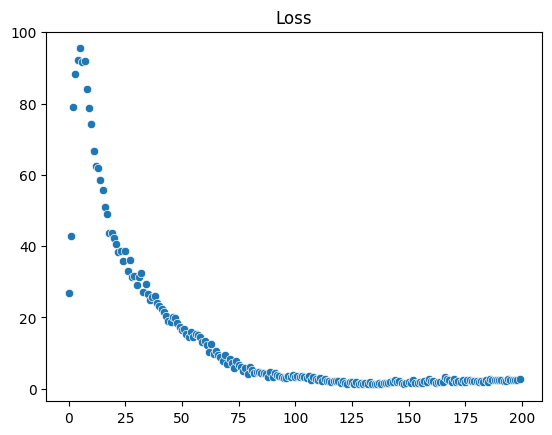

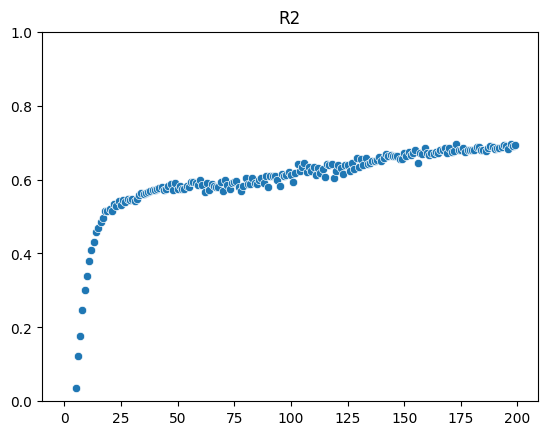

In [109]:
sns.scatterplot(history)
plt.title('Loss')
plt.show()
sns.scatterplot(history_r2)
plt.title('R2')
plt.ylim(0, 1)
plt.show()


In [110]:
torch.save(model.state_dict(), 'nn_r2_0.7_best.pkl')

In [ ]:
model.load_state_dict(torch.load('model_big_14.pkl'))
model.eval()

In [ ]:
round(r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()), 3)